# Feature Engineering

## Load Package

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

## Load Processed Data

In [24]:
X = pd.read_csv("../Dataset/X_scaled.csv")
y = pd.read_csv("../Dataset/y_clean.csv").squeeze()

In [25]:
print(X.shape, y.shape)

(28500, 5) (28500,)


## Train/Validation/Test Split

In [26]:
## Train/Validation/Test Split (70/20/10)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=2/9, random_state=42, stratify=y_temp)

## Feature Selection - Random Forest

### Hyperparameter Tuning with GridSearchCV (on RF)

In [27]:
# Defining the Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Setting up GridSearchCV
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [28]:
# Finding the Best Random Forest Configuration
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
best_params = rf_grid.best_params_

print("Best hyperparameters found:")
print(best_params)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best hyperparameters found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}


### Evaluate on Validation Set

In [29]:
# Evaluate on val set
y_val_pred = best_rf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("\nValidation Accuracy:", val_accuracy)
print("Validation F1-score:", val_f1)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.9198245614035088
Validation F1-score: 0.9173747966009763

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2873
           1       0.94      0.90      0.92      2827

    accuracy                           0.92      5700
   macro avg       0.92      0.92      0.92      5700
weighted avg       0.92      0.92      0.92      5700



### Feature Importance Ranking

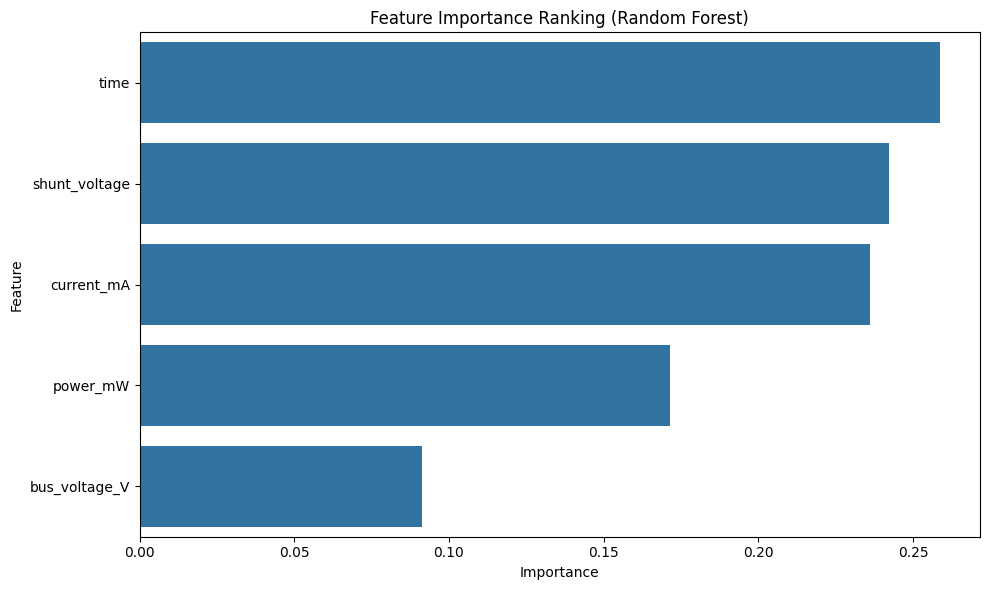

In [30]:
# Feature Importance Ranking
importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature Importance Ranking
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance Ranking (Random Forest)")
plt.tight_layout()
plt.show()

## Final Evaluation on Test Set

In [31]:
y_test_pred = best_rf.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

print("\nTest Accuracy:", acc_test)
print("Test F1-score:", f1_test)
print("Test AUC:", auc_test)


Test Accuracy: 0.9196491228070175
Test F1-score: 0.9174179588892896
Test AUC: 0.978033532561374


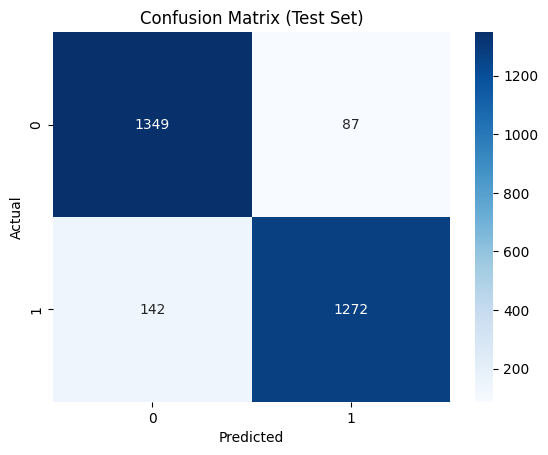

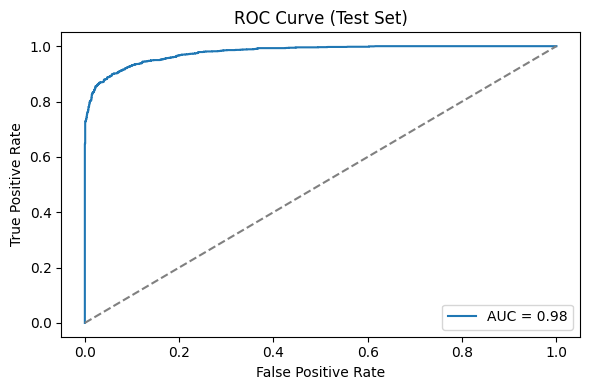

In [32]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

## Save Top N Features for MLP

In [33]:
# Create four feature sets based on importance thresholds
thresholds = {
    "all_features": X.columns.tolist(),
    "importance_gt_0.1": feature_importance_df[feature_importance_df['Importance'] > 0.1]['Feature'].tolist(),
    "importance_gt_0.2": feature_importance_df[feature_importance_df['Importance'] > 0.2]['Feature'].tolist()
}

# Save each set of features and corresponding data
for name, selected_features in thresholds.items():
    print(f"\nSaving feature set: {name} ({len(selected_features)} features)")
    X_sel = X[selected_features]
    X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
        X_sel, y, test_size=0.1, random_state=42, stratify=y
    )
    X_train_sel, X_val_sel, y_train_sel, y_val_sel = train_test_split(
        X_train_sel, y_train_sel, test_size=2/9, random_state=42, stratify=y_train_sel
    )


    X_train_sel.to_csv(f"../Dataset/MLP Data/X_train_{name}.csv", index=False)
    X_val_sel.to_csv(f"../Dataset/MLP Data/X_val_{name}.csv", index=False)
    X_test_sel.to_csv(f"../Dataset/MLP Data/X_test_{name}.csv", index=False)
    y_train_sel.to_csv(f"../Dataset/MLP Data/y_train_{name}.csv", index=False)
    y_val_sel.to_csv(f"../Dataset/MLP Data/y_val_{name}.csv", index=False)
    y_test_sel.to_csv(f"../Dataset/MLP Data/y_test_{name}.csv", index=False)



print("\nAll feature subsets saved for MLP training.")


Saving feature set: all_features (5 features)

Saving feature set: importance_gt_0.1 (4 features)

Saving feature set: importance_gt_0.2 (3 features)

All feature subsets saved for MLP training.
